# PyGIMLi - Electrical Resistivity Tomography

Using the ERT solver implemented provided by [PyGIMLi](https://www.pygimli.org/), 
we use different `cofi` solvers to solve the corresponding inverse problem.

<!--<badge>--><a href="https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/notebooks/pygimli_ert/pygimli_ert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/environment.yml) file
specifies a list of packages required to run the notebooks)

## 0. Import modules

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi

# !MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.4-Linux-x86_64.sh
# !MINICONDA_PREFIX=/usr/local
# !wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
# !chmod +x $MINICONDA_INSTALLER_SCRIPT
# !./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX
# !conda install -c gimli pygimli -y

# import sys
# _ = (sys.path.append("/usr/local/lib/python3.7/site-packages"))

We will need the following packages:

- `numpy` for matrices and matrix-related functions
- `matplotlib` for plotting
- `pygimli` for forward modelling of the problem
- `cofi` for accessing different inference solvers

Additionally, we wrap some `pygimli` code in file `pygimli_ert_lib.py` and import it
here for conciseness.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert

from cofi import BaseProblem, InversionOptions, Inversion

from pygimli_ert_lib import *

np.random.seed(42)

## 1. Define the problem

We first define the true model, the survey and map it on a computational mesh designed for the survey and true anomaly.

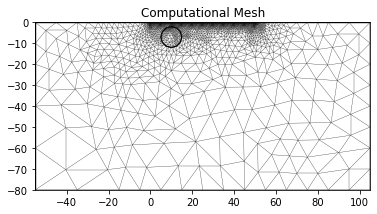

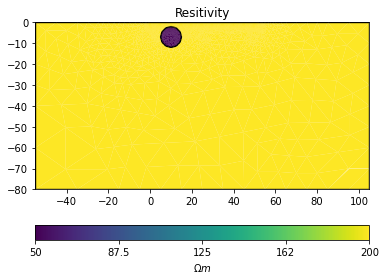

In [3]:
# PyGIMLi - define measuring scheme, geometry, forward mesh and true model
scheme = scheme_fwd()
geometry = geometry_true()
fmesh = mesh_fwd(scheme, geometry)
rhomap = markers_to_resistivity()
model_true = model_vec(rhomap, fmesh)

# plot the compuational mesh and the true model
ax=pg.show(fmesh)
ax[0].set_title("Computational Mesh")
ax=pg.show(fmesh,data=model_true,label=r"$\Omega m$")
ax[0].set_title("Resitivity");

Generate the synthetic data as a container with all the necessary information for plotting.

22/06/22 - 13:35:55 - pyGIMLi - INFO - Calculate geometric factors.


ModellingBase::setMesh() copying new mesh ... Found datafile: 51 electrodes
Found: 51 free-electrodes
rMin = 0.5, rMax = 100
NGauLeg + NGauLag for inverse Fouriertransformation: 13 + 4
Found non-Neumann domain
0.058 s
FOP updating mesh dependencies ... 0 s
Obtaining geometric factors (analytical)
Calculating response for model: min = 50 max = 200
Allocating memory for primary potential...... 0.012

No primary potential for secondary field calculation. Calculating analytically...
Factorize (Cholmod) matrix ... 0.031
Factorize (Cholmod) matrix ... 0.026
Factorize (Cholmod) matrix ... 0.026
Factorize (Cholmod) matrix ... 0.029
Factorize (Cholmod) matrix ... 0.03
Factorize (Cholmod) matrix ... 0.017
Factorize (Cholmod) matrix ... 0.017
Factorize (Cholmod) matrix ... 0.015
Factorize (Cholmod) matrix ... 0.015
Factorize (Cholmod) matrix ... 0.017
Factorize (Cholmod) matrix ... 0.021
Factorize (Cholmod) matrix ... 0.021
Factorize (Cholmod) matrix ... 0.021
Factorize (Cholmod) matrix ... 0.022

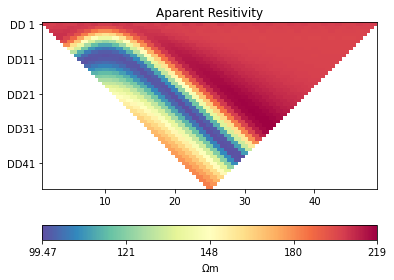

In [4]:
# PyGIMLi - generate data
survey = ert.simulate(fmesh, res=rhomap, scheme=scheme)

ax=ert.showERTData(survey,label=r"$\Omega$m")
ax[0].set_title("Aparent Resitivity")

y_obs = np.log(survey['rhoa'].array())

The inversion can use a different mesh and the mesh to be used should know nothing about the mesh that was designed based on the true model. We wrap two kinds of mesh as examples in the library code `pygimli_ert_lib.py`, namely triangular and rectangular mesh.

Use `imesh_tri = mesh_inv_triangular(scheme)` to initialise a triangular mesh, with the following optional arguments and corresponding default values:

- `start=[-15, 0]`
- `end=[65, -30]`

Use `imesh_rect = mesh_inv_rectangular()` to initislise a rectangular mesh, with the following optional arguments and corresponding default values:

- `x_start=-15`
- `x_stop=60`
- `x_num=11`
- `y_start=-30`
- `y_stop=0`
- `y_num=5`

Here we first demonstrate how to use a *triangular mesh*. Note that this makes the inversion problem under-determined.

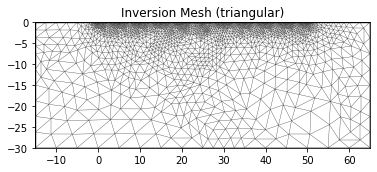

In [5]:
# PyGIMLi - quick demo of triangular mesh
imesh_tri = mesh_inv_triangular(scheme)

ax=pg.show(imesh_tri)
ax[0].set_title("Inversion Mesh (triangular)");

Check [here](https://github.com/inlab-geo/cofi-examples/tree/main/notebooks/pygimli_ert)
for inversion examples using triangular mesh.

For the purpose of this notebook, we use a *rectangular mesh* for a simple demonstration.

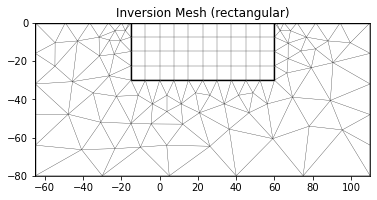

In [6]:
# PyGIMLi - create mesh for inversion
imesh = mesh_inv_rectangular()
ax = pygimli.show(imesh)
ax[0].set_title("Inversion Mesh (rectangular)");

With the inversion mesh created, we now define a starting model, forward operator and 
weighting matrix for regularisation using PyGIMLi.

In [7]:
# PyGIMLi - define the starting model on the inversion mesh
model_0 = starting_model(imesh)

# PyGIMLi - set up a forward operator with the inversion mesh
forward_operator = forward_oprt(scheme, imesh)

# PyGIMLi - extract the regularisation weighting matrix
Wm = weighting_matrix(forward_operator, imesh)

22/06/22 - 13:35:57 - Core - INFO - More than 50 regions, so we assume single regions only.


22/06/22 - 13:35:57 - Core - INFO - Applying *:* interregion constraints.


CoFI and other inference packages require a set of functions that provide the misfit, the jacobian the residual within the case of scipy standardised interfaces. All these functions are defined in the library file `pygimli_ert_lib.py`, so open this file if you'd like to find out the details. These functions are:

- `get_response`
- `get_jacobian`
- `get_residuals`
- `get_misfit`
- `get_regularisation`
- `get_gradient`
- `get_hessian`

With all the above forward operations set up with PyGIMLi, we now define the problem in `cofi`
by setting the problem information for a `BaseProblem` object.

In [8]:
# hyperparameters
lamda = 1

# cofi problem definition
ert_problem = BaseProblem()
ert_problem.name = "Electrical Resistivity Tomography defined through PyGIMLi"
ert_problem.set_forward(get_response, args=[forward_operator])
ert_problem.set_jacobian(get_jacobian, args=[forward_operator])
ert_problem.set_residual(get_residuals, args=[y_obs, forward_operator])
ert_problem.set_data_misfit(get_misfit, args=[y_obs, forward_operator, True])
ert_problem.set_regularisation(get_regularisation, lamda=lamda, args=[Wm, True])
ert_problem.set_gradient(get_gradient, args=[y_obs, forward_operator, lamda, Wm])
ert_problem.set_hessian(get_hessian, args=[y_obs, forward_operator, lamda, Wm])
ert_problem.set_initial_model(model_0)

Review what information is included in the `BaseProblem` object:

In [9]:
ert_problem.summary()

Summary for inversion problem: Electrical Resistivity Tomography defined through PyGIMLi
Model shape: (193,)
----------------------------------------------------------------------------------------
List of functions/properties set by you:
['gradient', 'hessian', 'residual', 'jacobian', 'data_misfit', 'regularisation', 'forward', 'initial_model', 'model_shape']
----------------------------------------------------------------------------------------
List of functions/properties created based on what you have provided:
['objective', 'hessian_times_vector', 'jacobian_times_vector']
----------------------------------------------------------------------------------------
List of functions/properties not set by you:
['objective', 'log_posterior', 'log_posterior_with_blobs', 'log_likelihood', 'log_prior', 'hessian_times_vector', 'jacobian_times_vector', 'data', 'data_covariance', 'data_covariance_inv', 'walkers_starting_pos', 'blobs_dtype', 'bounds', 'constraints']


## 2. Define the inversion options and run

### 2.1 SciPy's optimiser ([L-BFGS-B](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html#optimize-minimize-lbfgsb))

In [10]:
ert_problem.suggest_solvers();

Based on what you've provided so far, here are possible solvers:
{
    "optimisation": [
        "scipy.optimize.minimize",
        "scipy.optimize.least_squares"
    ],
    "linear least square": [],
    "sampling": []
}


In [11]:
inv_options = InversionOptions()
inv_options.set_tool("scipy.optimize.minimize")
inv_options.set_params(method="L-BFGS-B")

Review what's been defined for the inversion we are about to run:

In [12]:
inv_options.summary()

Summary for inversion options
Solving method: None set
Use `suggest_solving_methods()` to check available solving methods.
-----------------------------
Backend tool: `scipy.optimize.minimize` - SciPy's optimisers that minimises a scalar function with respect to one or more variables, check SciPy's documentation page for a list of methods
References: ['https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html']
Use `suggest_tools()` to check available backend tools.
-----------------------------
Solver-specific parameters: 
method = L-BFGS-B
Use `suggest_solver_params()` to check required/optional solver-specific parameters.


In [13]:
inv = Inversion(ert_problem, inv_options)
inv_result = inv.run()
inv_result.summary()

/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.10/site-packages/scipy/optimize/_minimize.py:548: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,
/home/jiawen/opt/mambaforge/envs/cofi_dev/lib/python3.10/site-packages/scipy/optimize/_minimize.py:554: RuntimeWarning: Method L-BFGS-B does not use Hessian-vector product information (hessp).
  warn('Method %s does not use Hessian-vector product '
22/06/22 - 13:35:57 - pyGIMLi - INFO - Creating forward mesh from region infos.


22/06/22 - 13:35:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


data misfit: 1330.5823132055143
raw regularisation: 0.0


data misfit: 1325.9161253098425
raw regularisation: 3.2377373769833095


data misfit: 1310.1261871672973
raw regularisation: 80.94343442458147


data misfit: 1322.2597025362134
raw regularisation: 10.893411239118068


data misfit: 1325.135359647151
raw regularisation: 4.464129155428508


data misfit: 1325.7525438833811
raw regularisation: 3.477259459812093


data misfit: 1325.9161253098425
raw regularisation: 3.2377373769833095


data misfit: 1264.5224957842584
raw regularisation: 1012.8227161445419


data misfit: 1310.7004959099122
raw regularisation: 54.45085548727792


data misfit: 1322.561654493989
raw regularisation: 8.579849219838769


data misfit: 1325.2029179367073
raw regularisation: 4.127365486399786


data misfit: 1325.7658184451464
raw regularisation: 3.4144837114354685


data misfit: 1325.8845086408692
raw regularisation: 3.27444109406676


data misfit: 1325.9094702083783
raw regularisation: 3.245433645438855


data misfit: 1325.9147261583928
raw regularisation: 3.2393545612568153


data misfit: 1325.915830240955
raw regularisation: 3.2380773358086925


data misfit: 1325.9160639187135
raw regularisation: 3.2378088557244338


data misfit: 1325.916113938105
raw regularisation: 3.2377524009730303


data misfit: 1325.916120497734
raw regularisation: 3.2377405226584632


data misfit: 1325.9161169013096
raw regularisation: 3.2377483623432126


data misfit: 1325.916117762816
raw regularisation: 3.237742145793666


data misfit: 1325.9161168403282
raw regularisation: 3.237746248715588


data misfit: 1325.9161186890526
raw regularisation: 3.2377429879089594


data misfit: 1325.9161177820065
raw regularisation: 3.2377423105919054


data misfit: 1325.916117762816
raw regularisation: 3.237742145793666


Summary for inversion result
SUCCESS
----------------------------
fun: 1329.1538599086095
jac: [ 3.92351568e-02  3.62388505e-01  1.32583944e-01  3.30928213e-01
  3.97340148e-01  1.92100742e-01  6.77337016e-01  4.43997635e-01
  8.19917918e-02  4.11619499e-01  2.44658540e-01  1.19599336e-01
  1.74484752e-01 -1.28990866e-01  3.89933063e-01  4.58226528e-03
  3.65620805e-01 -7.39992360e-02  1.08456923e-01  1.05594715e+00
  1.14109340e-01  2.71480696e-01  2.78963365e-01  3.14252928e-01
  7.47290440e-02  3.29102231e-01  1.97835110e-01  2.21707693e-01
  2.97465337e-02  2.38245925e-01  9.22820262e-02  4.63133553e-01
  8.24896289e-01  8.04083126e-02  1.29879329e-01  8.04685201e-02
  4.93248853e-01  3.57741286e-01  2.80073156e-01  1.60919374e-01
  9.84182884e-02  2.71168216e-01  8.74677541e-02  7.12422793e-01
  1.86988200e-01  4.22983650e-02  3.98849379e-01  2.18123716e-02
  9.42282361e-01 -8.35227088e-02  5.79934498e-01  1.72209869e-01
 -8.96485535e-02  2.19287591e-01 -1.07436286e-02  9.82549964

In [14]:
inv_result.success

True

Plot the results:

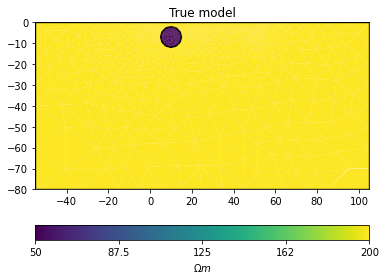

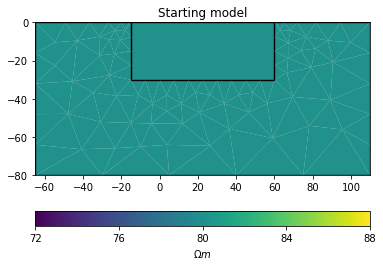

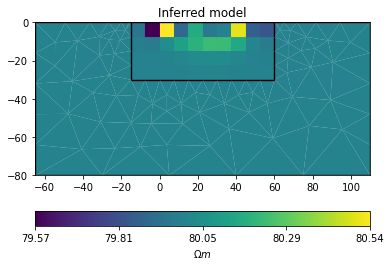

In [15]:
ax=pg.show(
    fmesh,
    data=(model_true),
    label=r"$\Omega m$"
)
ax[0].set_title("True model")

ax=pg.show(
    imesh,
    data=(model_0),
    label=r"$\Omega m$"
)
ax[0].set_title("Starting model")


ax=pg.show(
    imesh,
    data=(inv_result.model),
    label=r"$\Omega m$"
)
ax[0].set_title("Inferred model");

### 2.2 A custom [Newton's optimisation](https://en.wikipedia.org/wiki/Newton%27s_method_in_optimization) approach

Now we switch to a Newton's iterative approach written by ourselves, so you'll 
have a closer look at what's happening in the loop.

First of all, define our own solver.

In [16]:
from cofi.solvers import BaseSolver

class MyNewtonSolver(BaseSolver):
    def __init__(self, inv_problem, inv_options):
        __params = inv_options.get_params()
        self._niter = __params["niter"]
        self._step = __params["step"]
        self._verbose = __params["verbose"]
        self._model_0 = inv_problem.initial_model
        self._gradient = inv_problem.gradient
        self._hessian = inv_problem.hessian
        self._misfit = inv_problem.data_misfit if inv_problem.data_misfit_defined else None
        self._reg = inv_problem.regularisation if inv_problem.regularisation_defined else None
        self._obj = inv_problem.objective if inv_problem.objective_defined else None
        
    def __call__(self):
        current_model = np.array(self._model_0)
        for i in range(self._niter):
            term1 = self._hessian(current_model)
            term2 = - self._gradient(current_model)
            model_update = np.linalg.solve(term1, term2)
            current_model = np.array(current_model + self._step * model_update)
            if self._verbose:
                print("-" * 80)
                print(f"Iteration {i+1}")
                if self._misfit: self._misfit(current_model)
                if self._reg: self._reg(current_model)
                # if self._obj: print("objective func:", self._obj(current_model))
        return {"model": current_model, "success": True}

Now, make use of this custom solver and run inversion again:

In [17]:
inv_options_own_solver = InversionOptions()
inv_options_own_solver.set_tool(MyNewtonSolver)
inv_options_own_solver.set_params(niter=100, step=1, verbose=True)

inv_own_solver = Inversion(ert_problem, inv_options_own_solver)
inv_own_solver_res = inv_own_solver.run()
inv_own_solver_res.summary()

--------------------------------------------------------------------------------
Iteration 1
data misfit: 1323.2573456559178
raw regularisation: 94.16649894082346


--------------------------------------------------------------------------------
Iteration 2
data misfit: 1317.4272078955055
raw regularisation: 229.48689013717404


--------------------------------------------------------------------------------
Iteration 3
data misfit: 1312.3875589386835
raw regularisation: 369.53491395485776


--------------------------------------------------------------------------------
Iteration 4
data misfit: 1307.8671167205173
raw regularisation: 516.2007766775411


--------------------------------------------------------------------------------
Iteration 5
data misfit: 1303.7433628788465
raw regularisation: 670.4872551963658


--------------------------------------------------------------------------------
Iteration 6
data misfit: 1299.9466721173235
raw regularisation: 831.5077112730457


--------------------------------------------------------------------------------
Iteration 7
data misfit: 1296.4309126189428
raw regularisation: 997.5072421441563


--------------------------------------------------------------------------------
Iteration 8
data misfit: 1293.1619795849201
raw regularisation: 1166.564074418679


--------------------------------------------------------------------------------
Iteration 9
data misfit: 1290.1131660386352
raw regularisation: 1336.9004740503942


--------------------------------------------------------------------------------
Iteration 10
data misfit: 1287.2648959573182
raw regularisation: 1506.4536318019761


--------------------------------------------------------------------------------
Iteration 11
data misfit: 1284.5917115399986
raw regularisation: 1675.4520643416447


--------------------------------------------------------------------------------
Iteration 12
data misfit: 1282.0836967715286
raw regularisation: 1841.7785041739003


--------------------------------------------------------------------------------
Iteration 13
data misfit: 1279.7261683427234
raw regularisation: 2004.817760179452


--------------------------------------------------------------------------------
Iteration 14
data misfit: 1277.5065762891243
raw regularisation: 2164.053146405424


--------------------------------------------------------------------------------
Iteration 15
data misfit: 1275.413848255329
raw regularisation: 2319.0922045742673


--------------------------------------------------------------------------------
Iteration 16
data misfit: 1273.4380735439704
raw regularisation: 2469.6565086384794


--------------------------------------------------------------------------------
Iteration 17
data misfit: 1271.5703218992398
raw regularisation: 2615.5641054662833


--------------------------------------------------------------------------------
Iteration 18
data misfit: 1269.802452281493
raw regularisation: 2756.7121022866936


--------------------------------------------------------------------------------
Iteration 19
data misfit: 1268.1270525733867
raw regularisation: 2893.0614013557556


--------------------------------------------------------------------------------
Iteration 20
data misfit: 1266.5373347792688
raw regularisation: 3024.6239085576653


--------------------------------------------------------------------------------
Iteration 21
data misfit: 1265.0270539781234
raw regularisation: 3151.451900932686


--------------------------------------------------------------------------------
Iteration 22
data misfit: 1263.5904927321844
raw regularisation: 3273.629246272953


--------------------------------------------------------------------------------
Iteration 23
data misfit: 1262.222403867095
raw regularisation: 3391.2642734476954


--------------------------------------------------------------------------------
Iteration 24
data misfit: 1260.9179779188225
raw regularisation: 3504.4840572615963


--------------------------------------------------------------------------------
Iteration 25
data misfit: 1259.6725678193134
raw regularisation: 3613.4454972677972


--------------------------------------------------------------------------------
Iteration 26
data misfit: 1258.502191589262
raw regularisation: 3716.1820229800473


--------------------------------------------------------------------------------
Iteration 27
data misfit: 1257.3469199743697
raw regularisation: 3817.7585834965075


--------------------------------------------------------------------------------
Iteration 28
data misfit: 1256.2530919662247
raw regularisation: 3915.108213346423


--------------------------------------------------------------------------------
Iteration 29
data misfit: 1255.2069876814994
raw regularisation: 4008.6484014287153


--------------------------------------------------------------------------------
Iteration 30
data misfit: 1254.2035092375795
raw regularisation: 4098.678862026608


--------------------------------------------------------------------------------
Iteration 31
data misfit: 1253.2401690071813
raw regularisation: 4185.368049787677


--------------------------------------------------------------------------------
Iteration 32
data misfit: 1252.3146360082878
raw regularisation: 4268.883004794392


--------------------------------------------------------------------------------
Iteration 33
data misfit: 1251.4247948553937
raw regularisation: 4349.384936259577


--------------------------------------------------------------------------------
Iteration 34
data misfit: 1250.5687760968322
raw regularisation: 4427.02922194914


--------------------------------------------------------------------------------
Iteration 35
data misfit: 1249.7449277775004
raw regularisation: 4501.965972238666


--------------------------------------------------------------------------------
Iteration 36
data misfit: 1248.951729393642
raw regularisation: 4574.340055794306


--------------------------------------------------------------------------------
Iteration 37
data misfit: 1248.1878560131142
raw regularisation: 4644.291081909397


--------------------------------------------------------------------------------
Iteration 38
data misfit: 1247.452146782672
raw regularisation: 4711.953430562331


--------------------------------------------------------------------------------
Iteration 39
data misfit: 1246.7423838534326
raw regularisation: 4777.597863398626


--------------------------------------------------------------------------------
Iteration 40
data misfit: 1246.0609571951907
raw regularisation: 4841.016907487429


--------------------------------------------------------------------------------
Iteration 41
data misfit: 1245.4040532514625
raw regularisation: 4902.550396476436


--------------------------------------------------------------------------------
Iteration 42
data misfit: 1244.771751400214
raw regularisation: 4962.285947536715


--------------------------------------------------------------------------------
Iteration 43
data misfit: 1244.1634669645086
raw regularisation: 5020.329218672371


--------------------------------------------------------------------------------
Iteration 44
data misfit: 1243.5787118872786
raw regularisation: 5076.782305278331


--------------------------------------------------------------------------------
Iteration 45
data misfit: 1243.0170687055997
raw regularisation: 5131.743246225731


--------------------------------------------------------------------------------
Iteration 46
data misfit: 1242.4781880929543
raw regularisation: 5185.305704452492


--------------------------------------------------------------------------------
Iteration 47
data misfit: 1241.9617928195705
raw regularisation: 5237.559292537867


--------------------------------------------------------------------------------
Iteration 48
data misfit: 1241.4677052779748
raw regularisation: 5288.58837128953


--------------------------------------------------------------------------------
Iteration 49
data misfit: 1240.9957730426004
raw regularisation: 5338.474371844865


--------------------------------------------------------------------------------
Iteration 50
data misfit: 1240.5459394725474
raw regularisation: 5387.294069156537


--------------------------------------------------------------------------------
Iteration 51
data misfit: 1240.1182179672123
raw regularisation: 5435.120496816189


--------------------------------------------------------------------------------
Iteration 52
data misfit: 1239.7126596501594
raw regularisation: 5482.022947424715


--------------------------------------------------------------------------------
Iteration 53
data misfit: 1239.3293892422419
raw regularisation: 5528.067111278795


--------------------------------------------------------------------------------
Iteration 54
data misfit: 1238.9685976234134
raw regularisation: 5573.315183871394


--------------------------------------------------------------------------------
Iteration 55
data misfit: 1238.6305443865451
raw regularisation: 5617.8260011166385


--------------------------------------------------------------------------------
Iteration 56
data misfit: 1238.3155088566186
raw regularisation: 5661.655151912218


--------------------------------------------------------------------------------
Iteration 57
data misfit: 1238.0238735953292
raw regularisation: 5704.854982467557


--------------------------------------------------------------------------------
Iteration 58
data misfit: 1237.7560662875858
raw regularisation: 5747.474761233978


--------------------------------------------------------------------------------
Iteration 59
data misfit: 1237.5125752104223
raw regularisation: 5789.560680579178


--------------------------------------------------------------------------------
Iteration 60
data misfit: 1237.2939618184857
raw regularisation: 5831.153720426234


--------------------------------------------------------------------------------
Iteration 61
data misfit: 1237.1007771323614
raw regularisation: 5872.299505692962


--------------------------------------------------------------------------------
Iteration 62
data misfit: 1236.9337454946929
raw regularisation: 5913.031215421576


--------------------------------------------------------------------------------
Iteration 63
data misfit: 1236.7935856771185
raw regularisation: 5953.3835806465495


--------------------------------------------------------------------------------
Iteration 64
data misfit: 1236.6810842716293
raw regularisation: 5993.387822011192


--------------------------------------------------------------------------------
Iteration 65
data misfit: 1236.5957751014607
raw regularisation: 6033.252240246501


--------------------------------------------------------------------------------
Iteration 66
data misfit: 1236.5424752035437
raw regularisation: 6072.577063026526


--------------------------------------------------------------------------------
Iteration 67
data misfit: 1236.5185247848472
raw regularisation: 6111.671684831414


--------------------------------------------------------------------------------
Iteration 68
data misfit: 1236.525918638747
raw regularisation: 6150.519250466708


--------------------------------------------------------------------------------
Iteration 69
data misfit: 1236.565779440613
raw regularisation: 6189.13103909485


--------------------------------------------------------------------------------
Iteration 70
data misfit: 1236.639262963203
raw regularisation: 6227.516907927664


--------------------------------------------------------------------------------
Iteration 71
data misfit: 1236.747584913024
raw regularisation: 6265.6841279133205


--------------------------------------------------------------------------------
Iteration 72
data misfit: 1236.8919834721025
raw regularisation: 6303.6367751666785


--------------------------------------------------------------------------------
Iteration 73
data misfit: 1237.0737265039488
raw regularisation: 6341.3754637742295


--------------------------------------------------------------------------------
Iteration 74
data misfit: 1237.2941338203798
raw regularisation: 6378.897175171373


--------------------------------------------------------------------------------
Iteration 75
data misfit: 1237.5545238504576
raw regularisation: 6416.19522538752


--------------------------------------------------------------------------------
Iteration 76
data misfit: 1237.8562479869918
raw regularisation: 6453.2592183861825


--------------------------------------------------------------------------------
Iteration 77
data misfit: 1238.2006463270477
raw regularisation: 6490.075129698813


--------------------------------------------------------------------------------
Iteration 78
data misfit: 1238.5890434759128
raw regularisation: 6526.62536629132


--------------------------------------------------------------------------------
Iteration 79
data misfit: 1239.022737485001
raw regularisation: 6562.88895733382


--------------------------------------------------------------------------------
Iteration 80
data misfit: 1239.5030115828827
raw regularisation: 6598.841756547652


--------------------------------------------------------------------------------
Iteration 81
data misfit: 1240.0310475744823
raw regularisation: 6634.456721482226


--------------------------------------------------------------------------------
Iteration 82
data misfit: 1240.6079611712248
raw regularisation: 6669.704282633072


--------------------------------------------------------------------------------
Iteration 83
data misfit: 1241.2347813480014
raw regularisation: 6704.55272979191


--------------------------------------------------------------------------------
Iteration 84
data misfit: 1241.9124015823197
raw regularisation: 6738.9686700799675


--------------------------------------------------------------------------------
Iteration 85
data misfit: 1242.6415655268922
raw regularisation: 6772.9176094701415


--------------------------------------------------------------------------------
Iteration 86
data misfit: 1243.422849247908
raw regularisation: 6806.364450439426


--------------------------------------------------------------------------------
Iteration 87
data misfit: 1244.2566280627084
raw regularisation: 6839.274130744685


--------------------------------------------------------------------------------
Iteration 88
data misfit: 1245.1430874684352
raw regularisation: 6871.612196345249


--------------------------------------------------------------------------------
Iteration 89
data misfit: 1246.0869588955047
raw regularisation: 6903.035820882156


--------------------------------------------------------------------------------
Iteration 90
data misfit: 1247.074104288796
raw regularisation: 6934.328092639013


--------------------------------------------------------------------------------
Iteration 91
data misfit: 1248.1162329110393
raw regularisation: 6964.8258200735045


--------------------------------------------------------------------------------
Iteration 92
data misfit: 1249.2094060701054
raw regularisation: 6994.595187094231


--------------------------------------------------------------------------------
Iteration 93
data misfit: 1250.3522987396236
raw regularisation: 7023.633891584665


--------------------------------------------------------------------------------
Iteration 94
data misfit: 1251.5431164818485
raw regularisation: 7051.931725022619


--------------------------------------------------------------------------------
Iteration 95
data misfit: 1252.7799142618985
raw regularisation: 7079.477278316458


--------------------------------------------------------------------------------
Iteration 96
data misfit: 1254.060307230133
raw regularisation: 7106.260918645464


--------------------------------------------------------------------------------
Iteration 97
data misfit: 1255.3816779636434
raw regularisation: 7132.276186474324


--------------------------------------------------------------------------------
Iteration 98
data misfit: 1256.7409438671782
raw regularisation: 7157.520279255076


--------------------------------------------------------------------------------
Iteration 99
data misfit: 1258.1347462768529
raw regularisation: 7181.994222103519


--------------------------------------------------------------------------------
Iteration 100
data misfit: 1259.5593919005996
raw regularisation: 7205.702767211737
Summary for inversion result
SUCCESS
----------------------------
model: [ 63.61686191  60.29238842  61.12636419  69.34796888  60.67710174
  66.3653896   54.01906634  55.35104178  72.09521813  66.68833317
  68.72219894  75.78782787  71.74216819  85.96160098  56.70142657
  81.09120309  57.58156995  84.06476021  74.4198633   62.18826671
  75.27235152  61.46624023  58.3116592   51.91276054  55.15085364
  53.91890844  64.29773584  63.26513517  79.83406088  52.23220164
  76.08047933  48.93750711  47.92967989  72.22069708  55.27195229
  74.0942528   50.49838833  56.12852223  53.36680782  48.368536
  67.47799427  53.29500465  79.10547281  56.97605588  64.18758381
  65.84275636  53.26184008  81.4657754   52.352486    84.14568995
  57.7833139   63.44492612  85.17336068  53.87904253  82.17985686
  55.57210046  53.44251627  82.3063058

Plot the results:

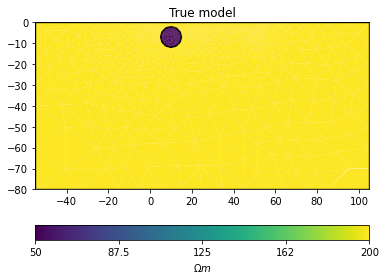

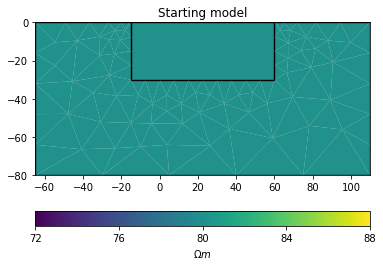

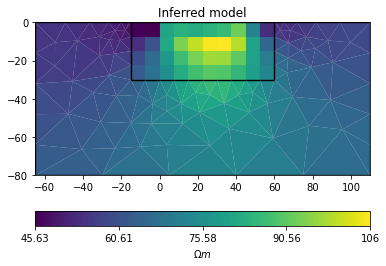

In [18]:
ax=pg.show(
    fmesh,
    data=(model_true),
    label=r"$\Omega m$"
)
ax[0].set_title("True model")

ax=pg.show(
    imesh,
    data=(model_0),
    label=r"$\Omega m$"
)
ax[0].set_title("Starting model")


ax=pg.show(
    imesh,
    data=(inv_own_solver_res.model),
    label=r"$\Omega m$"
)
ax[0].set_title("Inferred model");

### 2.3 Bayesian sampling with emcee (exploration)

CoFI needs more assumptions about the problem for a sampler to work - these are
the log of posterior distribution density and walkers' starting positions.

For the log posterior, we define here by specifying `log_prior` and `log_likelihood`.
And CoFI will combine them to get the `log_posterior`.

In [19]:
# hyperparameters
nwalkers = 32
nsteps = 10

# define log_likelihood
sigma = 1.0                                     # common noise standard deviation
Cdinv = np.eye(len(y_obs))/(sigma**2)           # inverse data covariance matrix
def log_likelihood(model):
    residual = ert_problem.residual(model)
    return -0.5 * residual @ (Cdinv @ residual).T

# define log_prior
m_lower_bound = np.zeros(model_0.shape)         # lower bound for uniform prior
m_upper_bound = np.ones(model_0.shape) * 250    # upper bound for uniform prior
def log_prior(model):                           # uniform distribution
    for i in range(len(m_lower_bound)):
        if model[i] < m_lower_bound[i] or model[i] > m_upper_bound[i]: return -np.inf
    return 0.0 # model lies within bounds -> return log(1)

# define walkers' starting positions
walkers_start = model_0 + 1e-6 * np.random.randn(nwalkers, model_0.shape[0])

# define them into cofi's BaseProblem object
ert_problem.set_log_likelihood(log_likelihood)
ert_problem.set_log_prior(log_prior)
ert_problem.set_walkers_starting_pos(walkers_start)

As usual, specify how you'd like to run the inversion and run it.

In [ ]:
# define inversion options
inv_options_emcee = InversionOptions()
inv_options_emcee.set_tool("emcee")
inv_options_emcee.set_params(nwalkers=nwalkers, nsteps=nsteps, progress=True)

from emcee.moves import GaussianMove
inv_options_emcee.set_params(moves=GaussianMove(1))

# run the inversion
inv_rect_emcee = Inversion(ert_problem, inv_options_emcee)
inv_rect_emcee_res = inv_rect_emcee.run()

Let's sub-sample 10 models from the posterior ensemble and plot them out.

You'll see that the results are not as good. That's because we've used only 32 walkers
and 10 sampling steps.

In [ ]:
sampler = inv_rect_emcee_res.sampler

In [ ]:
flat_samples = sampler.get_chain(discard=5, flat=True)
indices = np.random.randint(len(flat_samples), size=10) # get a random selection from posterior ensemble
for idx in indices:
    ax=pg.show(
        imesh,
        data=(flat_samples[idx]),
        label=r"$\Omega m$"
    )
    ax[0].set_title(f"Inferred model - sample {idx}");

Not satisfied with the results? Go back to the code cell under 2.3 and try with bigger numbers
of walkers and steps 😉

---
## Watermark

In [ ]:
watermark_list = ["cofi", "numpy", "scipy", "pygimli", "matplotlib", "emcee", "arviz"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))